In [75]:
import sqlite3
from pathlib import Path
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
sns.set()

In [8]:
db = Path("../data/japan-stats.db")

In [17]:
with sqlite3.connect(str(db)) as conn:
    df = pd.read_sql("select * from sqlite_master", conn)

df

,type,name,tbl_name,rootpage,sql
0,table,population_record,population_record,2,"CREATE TABLE ""population_record"" (\n""cat01"" TE..."
1,table,cat01,cat01,696,"CREATE TABLE ""cat01"" (\n""code"" TEXT,\n ""age_c..."
2,table,area,area,697,"CREATE TABLE ""area"" (\n""code"" TEXT,\n ""name"" ..."
3,table,time,time,698,"CREATE TABLE ""time"" (\n""code"" TEXT,\n ""year"" ..."


In [106]:
def get_population(pref: str, sex: str = None, year: int = None) -> DataFrame:
    with sqlite3.connect(str(db)) as conn:
        sql = f"""
            with area_modified as (
                select code, name as pref from area
            ),
            middle_table as (
                select
                    age_class * 5 as age, 
                    sex, 
                    pref, 
                    year, 
                    value as population
                from population_record as rcd
                left outer join cat01 on rcd.cat01 = cat01.code
                left outer join area_modified on rcd.area = area_modified.code
                left outer join time on rcd.time = time.code
            )
            select age, sum(population) as population
            from middle_table 
            where
                {f"pref = '{pref}'" if pref else ""}
                {f"and sex = '{sex}'" if sex else ""}
                {f"and year = '{year}'" if year else ""}
            group by age
            order by age
        """
        return pd.read_sql(sql, conn).astype({"age": str, "population": int})

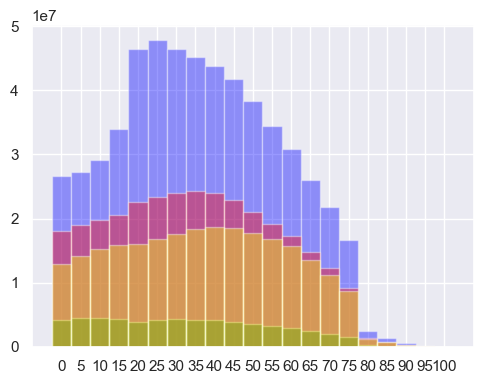

In [109]:
plt.figure(figsize = (5, 4))

df = get_population(pref = "東京都")
plt.bar(df["age"], df["population"], width=1, alpha = 0.4, color = 'blue')

df = get_population(pref = "愛知県")
plt.bar(df["age"], df["population"], width=1, alpha = 0.4, color = 'red')

df = get_population(pref = "沖縄県")
plt.bar(df["age"], df["population"], width=1, alpha = 0.4, color = 'green')

df = get_population(pref = "北海道")
plt.bar(df["age"], df["population"], width=1, alpha = 0.4, color = 'yellow')

plt.tight_layout()
plt.show()

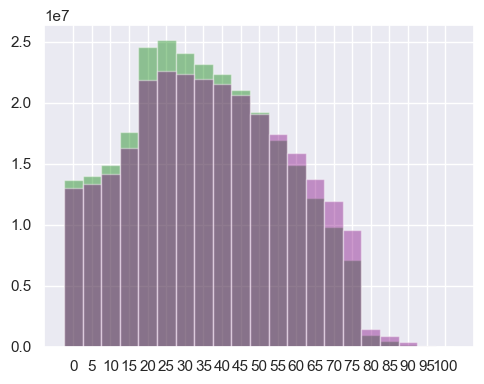

In [112]:
plt.figure(figsize = (5, 4))
pref = "東京都"

df = get_population(pref = pref, sex = 'M')
plt.bar(df["age"], df["population"], width=1, alpha = 0.4, color = 'green')

df = get_population(pref = pref, sex = 'F')
plt.bar(df["age"], df["population"], width=1, alpha = 0.4, color = 'purple')

plt.tight_layout()
plt.show()

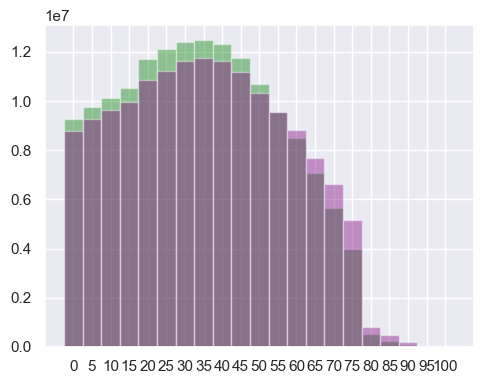

In [113]:
plt.figure(figsize = (5, 4))
pref = "愛知県"

df = get_population(pref = pref, sex = 'M')
plt.bar(df["age"], df["population"], width=1, alpha = 0.4, color = 'green')

df = get_population(pref = pref, sex = 'F')
plt.bar(df["age"], df["population"], width=1, alpha = 0.4, color = 'purple')

plt.tight_layout()
plt.show()

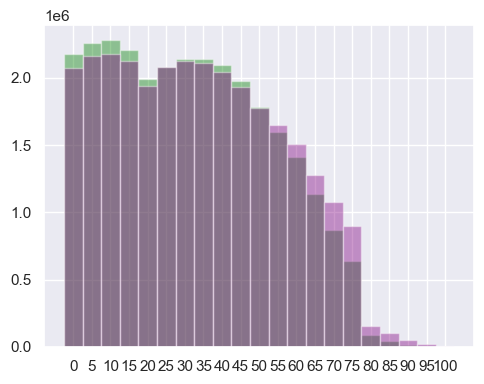

In [114]:
plt.figure(figsize = (5, 4))
pref = "沖縄県"

df = get_population(pref = pref, sex = 'M')
plt.bar(df["age"], df["population"], width=1, alpha = 0.4, color = 'green')

df = get_population(pref = pref, sex = 'F')
plt.bar(df["age"], df["population"], width=1, alpha = 0.4, color = 'purple')

plt.tight_layout()
plt.show()